In [1]:
import re
import os
import sys
import json
from imp import reload
from itertools import chain
from functools import partial

from pathlib import Path
base_dir = str(Path('..').resolve())
mesh_dir = base_dir + '/data/meshes'
ais_mesh_dir = mesh_dir + '/ais_meshes'
sys.path.append(base_dir + '/src')
import ais_pipeline_scripting_tools as utils
from ais_synapse_utils import load_ais_synapse_data

import tqdm.autonotebook as tqdm
import pandas as pd
import numpy as np
from scipy import spatial, sparse, stats
import seaborn as sns
import statsmodels.api as sm
from meshparty import trimesh_io, trimesh_vtk

import vtk
import matplotlib as mpl
plt = mpl.pyplot

from analysisdatalink.datalink_ext import AnalysisDataLinkExt as AnalysisDataLink
from annotationframeworkclient.infoservice import InfoServiceClient

from statsmodels.stats import multitest

from dotenv import load_dotenv
load_dotenv(dotenv_path=os.path.expanduser('~/.config/pinky100/.env'))

searching for scad in: /Users/caseyschneider-mizell/anaconda3/envs/jupyter_env/bin:/Users/caseyschneider-mizell/anaconda3/envs/jupyter_env/bin:/Users/caseyschneider-mizell/.poetry/bin:/Users/caseyschneider-mizell/Work/google-cloud-sdk/bin:/Users/caseyschneider-mizell/.nvm/versions/node/v8.11.3/bin:/Users/caseyschneider-mizell:/Users/caseyschneider-mizell/Library/Python/3.6/bin:/opt/local/bin:/opt/local/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Applications/VMware Fusion.app/Contents/Public:/Library/TeX/texbin:/opt/X11/bin:/Applications/OpenSCAD.app/Contents/MacOS


True

#### Visualization parameters

In [8]:
from paper_styles import *
set_rc_params(mpl)

#### Data Parameters

In [10]:
data_version = 141
ais_table = 'ais_bounds_v3'   # manual_ais for core, ais_bounds for all
chc_table = "is_chandelier_v4" # consult materialization for the best version
soma_table = os.getenv('SOMA_TABLE')
dataset_name = os.getenv('DATASET_NAME')
sql_database_uri_base = os.getenv('MATERIALIZATION_DATABASE_URI_BASE')
mesh_cv_path = os.getenv('CV_SOURCE')
mesh_endpoint = os.getenv('MESH_ENDPOINT')
synapse_table = os.getenv('AUTOMATED_SYNAPSE_TABLE')
voxel_resolution = np.array(os.getenv('VOXEL_RESOLUTION').split(',')).astype(int)

ais_synapse_data, aggregated_ais_syn_df, oids_failed, zero_syn_oids = \
    load_ais_synapse_data(chc_table, ais_table, data_version, base_dir + '/data')
print('\n')
if oids_failed is not None:
    if len(oids_failed) > 0:
        print('Warning: {} oids failed on AIS synapse computation'.format(len(oids_failed)))
    if len(zero_syn_oids) > 0:
        print('Warning: some oids had no AIS synapses')
        
plot_dir = base_dir + '/plots/v{}'.format(data_version)
if not os.path.exists(plot_dir):
    print('Making new plot directory...')
    os.mkdir(plot_dir)
    
dl = AnalysisDataLink(dataset_name=dataset_name,
                      sqlalchemy_database_uri=sql_database_uri_base,
                      materialization_version=data_version,
                      verbose=False)

chc_df = dl.query_cell_ids(chc_table)
chc_ids = np.unique(chc_df[chc_df.func_id==1].pt_root_id)

ais_df = dl.query_cell_ids(ais_table)
complete_ais_ids = np.unique(ais_df.pt_root_id)

# Use for the moment... probably need to fix when we explicitly set ids to ignore.
from analyzable_soma_ids import oids_to_ignore
oids_ignore = oids_to_ignore(data_version)

ais_id_to_analyze = set(complete_ais_ids.astype(int)).difference(zero_syn_oids).difference(oids_failed).difference(oids_ignore)
complete_ais_ids = np.array(list(ais_id_to_analyze))
analyzable_soma_ids = np.array(list(set(complete_ais_ids).difference(oids_ignore)))

in_analysis_set = np.isin(aggregated_ais_syn_df['post_pt_root_id'], list(ais_id_to_analyze))
aggregated_ais_syn_df = aggregated_ais_syn_df[in_analysis_set]

sv_df = dl.query_cell_types('soma_valence')
aggregated_ais_syn_df = aggregated_ais_syn_df.merge(sv_df[['pt_root_id', 'pt_position']].rename(columns={'pt_position':'soma_position'}),
                                                    how='left', left_on='post_pt_root_id', right_on='pt_root_id').drop(columns=('pt_root_id'))

soma_to_null = aggregated_ais_syn_df['soma_position'].map(lambda x: np.all(np.isnan(x)))
for ii in np.flatnonzero(soma_to_null):
    aggregated_ais_syn_df.at[ii, 'soma_position'] = np.full(3, np.nan)
    
aggregated_ais_syn_df['soma_x'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,0] * 4
aggregated_ais_syn_df['soma_y'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,1] * 4
aggregated_ais_syn_df['soma_z'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,2] * 40

aggregated_ais_syn_df['soma_x_um'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,0] * 4 / 1000
aggregated_ais_syn_df['soma_y_um'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,1] * 4 / 1000
aggregated_ais_syn_df['soma_z_um'] = np.vstack(aggregated_ais_syn_df['soma_position'].values)[:,2] * 40 / 1000

all_syn_filename = base_dir + '/data/in/all_synapses_onto_pycs_v{}.h5'.format(data_version)
if os.path.exists(all_syn_filename):
    all_post_synapses_df = pd.read_hdf(all_syn_filename, 'all_post_synapses_df')
else:
    syn_dfs = []
    for oid in tqdm.tqdm(np.unique(aggregated_ais_syn_df['post_pt_root_id'])):
        syn_dfs.append(dl.query_synapses(synapse_table, post_ids=[oid]))
    all_post_synapses_df = pd.concat(syn_dfs)
    all_post_synapses_df.to_hdf(all_syn_filename, 'all_post_synapses_df')
all_post_synapses_dec_df = all_post_synapses_df.merge(ais_synapse_data[['id', 'is_chandelier']], how='left', on='id')
non_ais_post_syns = all_post_synapses_dec_df[all_post_synapses_dec_df['is_chandelier'].map(np.isnan)]

full_soma_ids = dl.query_cell_ids('ais_analysis_soma')['pt_root_id'].values
arbor_ais_df = aggregated_ais_syn_df[np.isin(aggregated_ais_syn_df['post_pt_root_id'], full_soma_ids)]



Loading data from /Users/caseyschneider-mizell/Work/allen_work/data_analysis/ais_analysis_pipeline/data/in/data_v141_ais_bounds_v3_is_chandelier_v4.h5




In [14]:
original_data_version = 126
data_dir = base_dir + '/data/in'
soma_filename = data_dir + '/soma_area_summary_v{}.csv'.format(original_data_version)

if os.path.exists(soma_filename):
    soma_df = pd.read_csv(soma_filename)
else:
    print('No soma data for this version!')

if original_data_version != data_version:    
    from analysisdatalink import version_map
    soma_map_df = version_map.annotation_version_mapping('soma_valence', original_data_version, data_version, dataset_name, sql_database_uri_base)

    soma_oid_map = {}
    for _, row in soma_map_df.iterrows():
        orig_oid = row['pt_root_id_v{}'.format(original_data_version)]
        new_oid = row['pt_root_id_v{}'.format(data_version)]
        soma_oid_map[orig_oid] = new_oid
    soma_df['id'] = soma_df['id'].map(lambda x: soma_oid_map[x])
    
arbor_ais_df = arbor_ais_df.merge(soma_df, how='left', left_on='post_pt_root_id', right_on='id').drop(columns=['id', 'Unnamed: 0'])

In [11]:
import jitterbar

#### Spatial correlations of connectivity

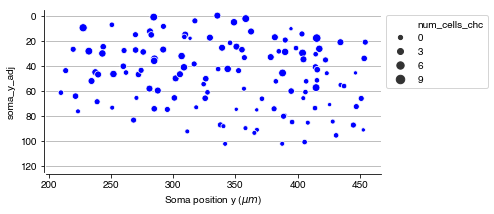

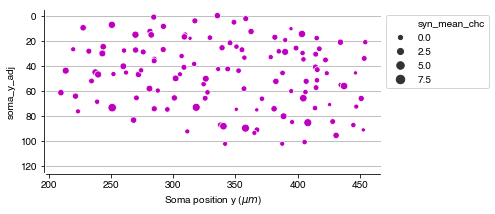

In [12]:
figsize=(6,6)

y_offset = 160
arbor_ais_df['soma_y_adj'] = arbor_ais_df['soma_y_um']-y_offset

fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='soma_x_um', y='soma_y_adj', size='num_cells_chc', data=arbor_ais_df, ax=ax, color='b')
ax.set_aspect(1)
ax.set_ylim((-5,125))
ax.invert_yaxis()
ax.legend().set_bbox_to_anchor([1,1])
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, ax=ax)

ax.set_xlabel('Soma position x ($\mu m$)')
ax.set_xlabel('Soma position y ($\mu m$)')

fig.savefig(plot_dir + '/num_cells_chc_vs_soma_position_xy.pdf')

figsize=(6,6)

y_offset = 160
arbor_ais_df['soma_y_adj'] = arbor_ais_df['soma_y_um']-y_offset

fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='soma_x_um', y='soma_y_adj', size='syn_mean_chc', data=arbor_ais_df, ax=ax, color='m')
ax.set_aspect(1)
ax.set_ylim((-5,125))
ax.invert_yaxis()
ax.legend().set_bbox_to_anchor([1,1])
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, ax=ax)

ax.set_xlabel('Soma position x ($\mu m$)')
ax.set_xlabel('Soma position y ($\mu m$)')

fig.savefig(plot_dir + '/syn_mean_chc_vs_soma_position_xy.pdf')

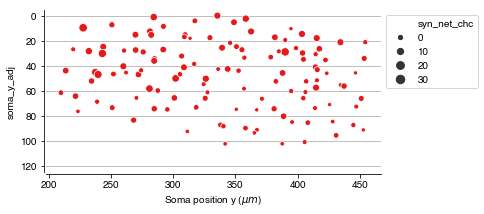

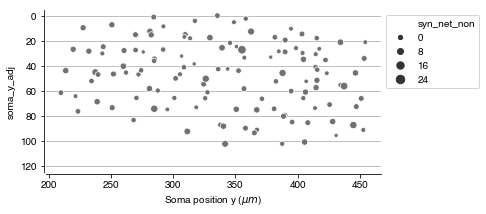

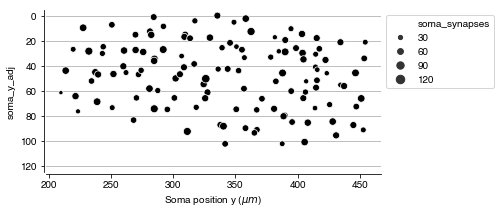

In [17]:
figsize=(6,6)

y_offset = 160
arbor_ais_df['soma_y_adj'] = arbor_ais_df['soma_y_um']-y_offset

fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='soma_x_um', y='soma_y_adj', size='syn_net_chc', data=arbor_ais_df, ax=ax, color=chc_color)
ax.set_aspect(1)
ax.set_ylim((-5,125))
ax.invert_yaxis()
ax.legend().set_bbox_to_anchor([1,1])
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, ax=ax)

ax.set_xlabel('Soma position x ($\mu m$)')
ax.set_xlabel('Soma position y ($\mu m$)')

fig.savefig(plot_dir + '/ais_input_vs_soma_position_xy.pdf', bbox_inches="tight")

###

fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='soma_x_um', y='soma_y_adj', size='syn_net_non', data=arbor_ais_df, ax=ax, color=non_color)
ax.set_aspect(1)
ax.set_ylim((-5,125))
ax.invert_yaxis()
ax.legend().set_bbox_to_anchor([1,1])
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, ax=ax)

ax.set_xlabel('Soma position x ($\mu m$)')
ax.set_xlabel('Soma position y ($\mu m$)')

fig.savefig(plot_dir + '/ais_input_non_vs_soma_position_xy.pdf', bbox_inches="tight")
###

figsize=(6,6)

y_offset = 160
arbor_ais_df['soma_y_adj'] = arbor_ais_df['soma_y_um']-y_offset

fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='soma_x_um', y='soma_y_adj', size='soma_synapses', data=arbor_ais_df, ax=ax, color='k')
ax.set_aspect(1)
ax.set_ylim((-5,125))
ax.invert_yaxis()
ax.legend().set_bbox_to_anchor([1,1])
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, ax=ax)

ax.set_xlabel('Soma position x ($\mu m$)')
ax.set_xlabel('Soma position y ($\mu m$)')

fig.savefig(plot_dir + '/soma_input_vs_soma_position_xy.pdf', bbox_inches="tight")

---

In [10]:
from meshparty import skeletonize
from ossuary import synapse_flow

def extract_axon_mesh(oid, dl, soma_radius, dataset_name=dataset_name):
    soma_df = dl.query_cell_types('soma_valence_v2')
    soma_loc = soma_df[soma_df['pt_root_id']==oid].values[0] * voxel_resolution
    chc_mesh = mm.mesh(seg_id=oid)
    chc_mesh.add_link_edges(int(oid), dataset_name)
    chc_sk = skeletonize.skeletonize_mesh(chc_mesh,
                                          soma_pt=soma_loc,
                                          soma_radius=soma_radius)
    pre_syn_df = dl.query_synapses(synapse_table, pre_ids=[oid])
    post_syn_df = dl.query_synapses(synapse_table, post_ids=[oid])
    
    pre_pts = np.vstack(pre_syn_df[pre_syn_df['pre_pt_root_id']==oid]['ctr_pt_position']) * voxel_resolution
    _, pre_inds = chc_mesh.kdtree.query(pre_pts)
    pre_skinds = chc_sk.mesh_to_skel_map[pre_inds]

    post_pts = np.vstack(post_syn_df[post_syn_df['post_pt_root_id']==oid]['ctr_pt_position']) * voxel_resolution
    _, post_inds = chc_mesh.kdtree.query(post_pts)
    post_skinds = chc_sk.mesh_to_skel_map[post_inds]

    ax_split, qual = synapse_flow.find_axon_split(chc_sk, pre_skinds, post_skinds, return_quality=True, extend_to_segment=True)
    return chc_mesh.apply_mask(np.isin(chc_sk.mesh_to_skel_map, chc_sk.downstream_nodes(ax_split)))

In [11]:
mm = trimesh_io.MeshMeta(disk_cache_path=mesh_dir,
                         cache_size=0, cv_path=mesh_cv_path)

ais_meshes = []
for oid in complete_ais_ids:
    ais_file = ais_mesh_dir + '/{}_ais.h5'.format(oid)
    if os.path.exists(ais_file):
        ais_mesh = mm.mesh(filename=ais_file)
        ais_meshes.append(ais_mesh)
    else:
        ais_meshes.append(None)
        print('{} AIS not found!'.format(oid))

in_df = dl.query_cell_types('interneurons_putative_ai', )
chc_soma_ids = in_df[in_df['cell_type']=='chandelier']['pt_root_id'].values
        
chc_meshes = {}
for oid in chc_ids:
    if oid not in chc_soma_ids:
        chc_mesh = mm.mesh(seg_id=oid)
    else:
        if os.path.exists(mesh_dir + '/{}_axon.h5'.format(oid)):
            chc_mesh = mm.mesh(filename=mesh_dir + '/{}_axon.h5'.format(oid))
        else:
            chc_mesh = extract_axon_mesh(oid, dl, soma_radius=10000)
            chc_mesh.write_to_file(mesh_dir + '/{}_axon.h5'.format(oid))
    chc_meshes[oid] = chc_mesh

---
#### Use the multi-utilities to get potential synapses from meshes

In [ ]:
from itertools import product
from collections import defaultdict

from multiwrapper import multiprocessing_utils as mu
def _multi_count_neighbors(args):
    ais_kdt, chc_kdt, d_max = args
    return ais_kdt.count_neighbors(chc_kdt, d_max)

In [ ]:
d_max = 10000
multi_args = []
for ais_ind, chc_oid in product(range(len(ais_meshes)), chc_meshes.keys()):
    ais_mesh = ais_meshes[ais_ind]
    chc_mesh = chc_meshes[chc_oid]
    multi_args.append([ais_mesh.kdtree, chc_mesh.kdtree, d_max])
    
n_neib_list = mu.multiprocess_func(_multi_count_neighbors, multi_args, verbose=True)

is_potential = defaultdict(dict)
n_neib_list_copy = n_neib_list.copy()
for ais_ind, chc_oid in product(range(len(ais_meshes)), chc_meshes.keys()):
    is_potential[ais_ind][chc_oid] = n_neib_list_copy.pop(0)>0

In [ ]:
num_pot_df = pd.DataFrame({'pyc_root_id': complete_ais_ids, 'num_potential':[sum(is_potential[ii].values()) for ii in range(len(complete_ais_ids))]})
arbor_ais_df_pot = arbor_ais_df.merge(num_pot_df, left_on='post_pt_root_id', right_on='pyc_root_id', how='left').drop(columns=['pyc_root_id'])

In [ ]:
arbor_ais_df_pot['conn_frac'] = arbor_ais_df_pot['num_cells_chc'] / arbor_ais_df_pot['num_potential'] 

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.hist(arbor_ais_df_pot['conn_frac'], bins=np.arange(0,1.01,0.05), edgecolor='w', color='k')
ax.grid(True, axis='y')
ax.set_axisbelow(True)
sns.despine(offset=2, trim=False, ax=ax)
ax.set_xlabel('Connectivity fraction')
ax.set_yticks(np.arange(0,21,5))
ax.set_ylabel('# AISes')

arbor_ais_df_pot['conn_frac'].describe()
fig.savefig(fname=plot_dir+'/connectivity_fraction_histogram.pdf')

conn_fract_described_df = arbor_ais_df_pot['conn_frac'].describe(percentiles=[])
conn_fract_described_df.to_csv(plot_dir + '/connectivity_fraction_summary_v{}.csv'.format(data_version))

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
y_offset = 160
arbor_ais_df['soma_y_adj'] = arbor_ais_df['soma_y_um']-y_offset
rel_ais = np.full(len(arbor_ais_df_pot), True)
# rel_ais = arbor_ais_df_pot['conn_frac']<=0.5

sns.scatterplot(x='conn_frac', y='soma_y_adj', data=arbor_ais_df_pot[rel_ais], ax=ax, color='k', s=30, alpha=0.8)
ax.invert_yaxis()
ax.set_xlabel('Connectivity fraction')
ax.set_ylabel('Soma depth')

ax.grid(True, axis='both')
ax.set_axisbelow(True)
sns.despine(offset=2, trim=False, ax=ax)
fig.savefig(fname=plot_dir+'/conn_frac_vs_soma_y.pdf')


fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x='conn_frac', y='n_syn_soma', data=arbor_ais_df_pot[rel_ais], ax=ax, color='k', s=30, alpha=0.8)
ax.set_xlabel('Connectivity fraction')
ax.set_ylabel('# Syn Soma')

ax.grid(True, axis='both')
ax.set_axisbelow(True)
sns.despine(offset=2, trim=False, ax=ax)
fig.savefig(fname=plot_dir+'/conn_frac_vs_soma_synapses.pdf')


fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x='num_potential', y='soma_y_adj', data=arbor_ais_df_pot[rel_ais], ax=ax, color='k', s=30, alpha=0.8)
ax.invert_yaxis()
ax.set_xlabel('# Potential')
ax.set_ylabel('Soma depth')

ax.grid(True, axis='both')
ax.set_axisbelow(True)
sns.despine(offset=2, trim=False, ax=ax)
fig.savefig(fname=plot_dir+'/num_potential_vs_soma_y.pdf')


fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x='num_potential', y='n_syn_soma', data=arbor_ais_df_pot[rel_ais], ax=ax, color='k', s=30, alpha=0.8)
ax.set_xlabel('# Potential')
ax.set_ylabel('# Syn Soma')

ax.grid(True, axis='both')
ax.set_axisbelow(True)
sns.despine(offset=2, trim=False, ax=ax)
fig.savefig(fname=plot_dir+'/num_potential_vs_soma_synapses.pdf')


In [ ]:
import statsmodels.api as sm
from statsmodels.stats import multitest

In [ ]:
stars = [0.05, 0.01, 0.001]

def assign_stars(pvals, star_ths):
    n_stars = np.zeros(len(pvals))
    for ii, star in enumerate(star_ths):
        n_stars[pvals < star] = ii+1
    return n_stars

def plot_stars(xs, ys, n_stars, ax, xytext=(5,0), fontsize=12, fontweight=100, color=None, horizontalalignment='left'):
    for x, y, ns in zip(xs, ys, n_stars):
        if ns>0:
            ax.annotate('*'*int(ns),
                         (x,y),
                         textcoords='offset points',
                         xytext=xytext,
                         fontsize=fontsize,
                         fontweight=fontweight,
                         color=color,
                         horizontalalignment=horizontalalignment)

In [ ]:
columns = ['n_syn_soma', 'soma_y_um', 'syn_net_non', 'soma_x_um']
figsize=(4,3)

xmin = 57000
# xmin = -np.inf
# rel_ais = (arbor_ais_df_pot['soma_x']>xmin*4)
rel_ais = np.full(len(arbor_ais_df), True)

X = arbor_ais_df_pot[rel_ais][columns].values.astype(float)
y = arbor_ais_df_pot[rel_ais]['conn_frac'].values.astype(float)

X[:,1] = -1*X[:,1]
Xz = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
yz = (y-np.mean(y)) / np.std(y)

mod = sm.OLS(yz, Xz)
res_pot = mod.fit()
# print(res_pot.summary())
X = arbor_ais_df_pot[rel_ais][columns].values.astype(float)
y = arbor_ais_df_pot[rel_ais]['num_potential'].values.astype(float)

X[:,1] = -1*X[:,1]
Xz = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
yz = (y-np.mean(y)) / np.std(y)

mod = sm.OLS(yz, Xz)
res_numpot = mod.fit()

###

fig, ax = plt.subplots(figsize=figsize)

param_vals_pot = res_pot.params
conf_ints_pot = res_pot.conf_int()
xvals_pot = np.arange(len(param_vals_pot))
for ii in np.arange(len(param_vals_pot)):
    ax.plot([xvals_pot[ii], xvals_pot[ii]], conf_ints_pot[ii,:], linestyle='-', color='k')
ax.plot(xvals_pot, param_vals_pot, marker='s', linestyle='', markeredgecolor='w', color='k')

param_vals_numpot = res_numpot.params
conf_ints_numpot = res_numpot.conf_int()
xvals_numpot = np.arange(len(param_vals_numpot)) + 0.3
for ii in np.arange(len(param_vals_numpot)):
    ax.plot([xvals_numpot[ii], xvals_numpot[ii]], conf_ints_numpot[ii,:], linestyle='-', color='g')
ax.plot(xvals_numpot, param_vals_numpot, marker='s', linestyle='', markeredgecolor='w', color='g')

## Assign stars
_, p_pot_coef_corr, _, _ = multitest.multipletests(res_pot.pvalues)
n_star_corr = assign_stars(p_pot_coef_corr, stars)
plot_stars(xvals_pot, conf_ints_pot[:,1], n_star_corr, ax, xytext=(0,0), color='k', horizontalalignment='center')

_, p_numpot_coef_corr, _, _ = multitest.multipletests(res_numpot.pvalues)
plot_stars(xvals_numpot, conf_ints_numpot[:,1], assign_stars(p_numpot_coef_corr, stars), ax, xytext=(0,0), color='k', horizontalalignment='center')

ax.set_xticks(np.arange(len(param_vals_pot))+0.15)
ax.set_ylim([-0.5, 0.9])
ax.set_yticks(np.arange(-0.4,0.9,0.2))
sns.despine(ax=ax, offset=5, trim=True)

_=ax.set_xticklabels(['# Syn. soma', 'Soma pos. y', 'Syn. Non', 'Soma pos. x'], rotation=45)
ax.plot([-0.5,len(param_vals_pot)-1+0.8],[0,0], 'k', zorder=1, linewidth=2)
plt.grid(axis='y', which='major')
ax.set_axisbelow(True)

line_chc = plt.Line2D([0],[0], linestyle='-', color='k')
line_non = plt.Line2D([0],[0], linestyle='-', color='g')
ax.legend([line_chc, line_non],['Conn. Frac.', '# Potential'])

ax.set_ylabel('Standardized coefficient')
ax.set_xlim([-0.15, len(param_vals_pot)+0.45-1])
fig.savefig(plot_dir + '/potential_connectivity_standardized_coefficients.pdf')

ols_res_df = pd.DataFrame({'Variable':['# Syn. soma', 'Soma pos. y', 'Syn. Non', 'Soma pos. x'],
                           'ConnFrac corr':res_pot.params,
                           'ConnFrac pval':p_pot_coef_corr,
                           'NumPot corr':res_numpot.params,
                           'NumPot pval':p_numpot_coef_corr,
                           'ConnFrac R2': [res_pot.rsquared, np.nan, np.nan, np.nan],
                           'NumPot R2': [res_numpot.rsquared, np.nan, np.nan, np.nan],
                          })
ols_res_df.to_csv(plot_dir + '/potential_connectivity_ols_fit.csv', index=False)
ols_res_df

---
Correct potential synapses on AIS

In [ ]:
svs = cv.CloudVolumeFactory(mesh_cv_path, mip=5, autocrop=True)

In [ ]:
np.array(svs.bounds.to_list()).reshape(2,3)

In [ ]:
mip=5
cv_path = mesh_cv_path
svs = cv.CloudVolumeFactory(cv_path, mip=mip)

xmin = 1910
xmax = 1930
ymin = 1270
ymax = 1290
zmin = 2170
zmax = 2180

X, Y, Z = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin,ymax), np.arange(zmin, zmax))

xyzs = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T * svs.resolution

In [ ]:
sv_holder = np.zeros(X.shape)
cv_bounds = np.array(svs.bounds.to_list()).reshape(2,3)
xslice = slice(max((xmin, cv_bounds[0][0])), min((xmax, cv_bounds[1][0])), 1)
yslice = slice(max((ymin, cv_bounds[0][1])), min((ymax, cv_bounds[1][1])), 1)
zslice = slice(max((zmin, cv_bounds[0][2])), min((zmax, cv_bounds[1][2])), 1)
sv_dat = np.squeeze(svs._cv[xslice, yslice, zslice])


In [ ]:
slice(max((ymin, cv_bounds[0][1])), min((ymax, cv_bounds[1][1])), 1)

In [ ]:
test = np.array(sv_dat) + 1

In [ ]:
test.shape

In [ ]:
np.arange(xslice.start,xslice.stop)-xmin

In [ ]:
np.arange(yslice.start,yslice.stop)-ymin

In [ ]:
sv_holder[np.arange(xslice.start,xslice.stop)-xmin]\
         [:,np.arange(yslice.start,yslice.stop)-ymin]\
         [:,:,np.arange(zslice.start,zslice.stop)-zmin].shape

In [ ]:
Xi, Yi, Zi = np.meshgrid(np.arange(xslice.start,xslice.stop)-xmin,
                         np.arange(yslice.start,yslice.stop)-ymin,
                         np.arange(zslice.start,zslice.stop)-zmin)
sv_holder[Xi.ravel(), Yi.ravel(), Zi.ravel()] = sv_dat.ravel()

In [ ]:
sv_holder[Xi.ravel(), Yi.ravel(), Zi.ravel()] = test.ravel()

In [ ]:
sv_holder[0]

In [ ]:
sv_holder[np.arange(xslice.start,xslice.stop)-xmin]\
         [:,np.arange(yslice.start,yslice.stop)-ymin]\
         [:,:,np.arange(zslice.start,zslice.stop)-zmin] = test

In [ ]:
np.arange(xslice.start,xslice.stop)-xmin

In [12]:
import cloudvolume as cv
def segmentation_mesh_zeros(mesh, dmax_vec, cv_path, mip=5, cap_y=True):
    svs = cv.CloudVolumeFactory(cv_path, mip=mip)
    
    print('\tComputing grid coordinates...')
    xmin, ymin, zmin = ((mesh.bounds[0] - max(dmax_vec)) / svs.resolution).astype(int)
    xmax, ymax, zmax = ((mesh.bounds[1] + max(dmax_vec)) / svs.resolution).astype(int)
    if cap_y:
        ymin = (mesh.bounds[0][1] / svs.resolution[1]).astype(int)
        ymax = (mesh.bounds[1][1] / svs.resolution[1]).astype(int)

    X, Y, Z = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin,ymax), np.arange(zmin, zmax), indexing='ij')

    xyzs = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T * svs.resolution
    try:
        dsp, _ = mesh.pykdtree.query(xyzs, distance_upper_bound=max(dmax_vec))
    except:
        dsp, _ = mesh.kdtree.query(xyzs, distance_upper_bound=max(dmax_vec))

    print('\tDownloading segmentation...')
    sv_holder = np.zeros(X.shape)
    cv_bounds = np.array(svs.bounds.to_list()).reshape(2,3)
    xslice = slice(max((xmin, cv_bounds[0][0])), min((xmax, cv_bounds[1][0])), 1)
    yslice = slice(max((ymin, cv_bounds[0][1])), min((ymax, cv_bounds[1][1])), 1)
    zslice = slice(max((zmin, cv_bounds[0][2])), min((zmax, cv_bounds[1][2])), 1)
    sv_dat = np.squeeze(svs._cv[xslice, yslice, zslice])
    
    Xi, Yi, Zi = np.meshgrid(np.arange(xslice.start,xslice.stop)-xmin,
                             np.arange(yslice.start,yslice.stop)-ymin,
                             np.arange(zslice.start,zslice.stop)-zmin,
                             indexing='ij')
    sv_holder[Xi.ravel(), Yi.ravel(), Zi.ravel()] = sv_dat.ravel()
    
    print('\tComputing proximate grid volume...')
    outside_seg = (sv_holder==0).astype(int).ravel()
    frac_out = []
    for dmax in dmax_vec:
        valid=dsp<dmax
        vox_outside = np.sum(outside_seg[valid])
        vox_total = np.sum(valid)
        frac_out.append(vox_outside / vox_total)
    return frac_out

In [13]:
import time
t0 = time.time()
f = segmentation_mesh_zeros(ais_meshes[0], [5000, 7500, 10000], mesh_cv_path)
print(time.time()-t0)

	Computing grid coordinates...


Downloading: 242it [00:24,  7.08it/s]                         


	Computing proximate grid volume...
75.64976596832275


[1.5781478288946873e-06, 0.0001567687268616101, 0.0001670287053952162]

In [ ]:
import numpy as np

In [ ]:
X, Y, Z = np.meshgrid(np.arange(0,129), np.arange(0,300), np.arange(0,40), indexing='ij')

In [ ]:
X.shape

In [ ]:
mip=5
cv_path = mesh_cv_path
dmax_vec = [5000, 7500, 10000]
mesh = ais_meshes[0]
cap_y = False

svs = cv.CloudVolumeFactory(cv_path, mip=mip)

print('\tComputing grid coordinates...')
xmin, ymin, zmin = ((mesh.bounds[0] - max(dmax_vec)) / svs.resolution).astype(int)
xmax, ymax, zmax = ((mesh.bounds[1] + max(dmax_vec)) / svs.resolution).astype(int)
if cap_y:
    ymin = (mesh.bounds[0][1] / svs.resolution[1]).astype(int)
    ymax = (mesh.bounds[1][1] / svs.resolution[1]).astype(int)

X, Y, Z = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin,ymax), np.arange(zmin, zmax), indexing='ij')

xyzs = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T * svs.resolutioæn
try:
    dsp, _ = mesh.pykdtree.query(xyzs, distance_upper_bound=max(dmax_vec))
except:
    dsp, _ = mesh.kdtree.query(xyzs, distance_upper_bound=max(ddmax_vec))

print('\tDownloading segmentation...')
sv_holder = np.zeros(X.shape)
cv_bounds = np.array(svs.bounds.to_list()).reshape(2,3)
xslice = slice(max((xmin, cv_bounds[0][0])), min((xmax, cv_bounds[1][0])), 1)
yslice = slice(max((ymin, cv_bounds[0][1])), min((ymax, cv_bounds[1][1])), 1)
zslice = slice(max((zmin, cv_bounds[0][2])), min((zmax, cv_bounds[1][2])), 1)
sv_dat = np.squeeze(svs._cv[xslice, yslice, zslice])

Xi, Yi, Zi = np.meshgrid(np.arange(xslice.start,xslice.stop)-xmin,
                         np.arange(yslice.start,yslice.stop)-ymin,
                         np.arange(zslice.start,zslice.stop)-zmin, indexing='ij')
sv_holder[Xi.ravel(), Yi.ravel(), Zi.ravel()] = sv_dat.ravel()

print('\tComputing proximate grid volume...')
outside_seg = (sv_holder==0).astype(int).ravel()
frac_out = []
for dmax in dmax_vec:
    valid=dsp<dmax
    vox_outside = np.sum(outside_seg[valid])
    vox_total = np.sum(valid)
    frac_out.append(vox_outside / vox_total)


In [ ]:
frac_out

In [ ]:
np.arange(xmin, xmax).shape

In [ ]:
sv_dat = svs._cv[xslice, yslice, zslice]


In [ ]:
sv_dat.shape

In [ ]:
sv_dat.shape

In [ ]:
Xi.shape

In [ ]:
X.shape

In [ ]:
dmaxs = [5000, 7500, 10000]
f_outs = []
for mesh in tqdm.tqdm(ais_meshes):
    f = segmentation_mesh_zeros(mesh, dmaxs, mesh_cv_path)
    f_outs.append(f)

In [ ]:
1

In [ ]:
ds = [5000, ]
overlap_fs = []

In [ ]:
cap_y = True

In [ ]:
mip = 5
dmax = 10000
svs = cv.CloudVolumeFactory(mesh_cv_path, mip=mip)

In [ ]:
mesh = ais_meshes[0]

In [ ]:
dmax = 10000
xmin, ymin, zmin = ((mesh.bounds[0] - dmax) / svs.resolution).astype(int)
xmax, ymax, zmax = ((mesh.bounds[1] + dmax) / svs.resolution).astype(int)

In [ ]:
sv_dat = svs._cv[xmin:xmax, ymin:ymax, zmin:zmax]
outside_seg = sv_dat==0

In [ ]:
sv_dat = svs._cv[xmin:xmax, ymin:ymax, zmin:zmax]
outside_seg = sv_dat==0

In [ ]:
outside_seg = np.squeeze(outside_seg)

In [ ]:
X, Y, Z = np.meshgrid(np.arange(xmin, xmax), np.arange(ymin,ymax), np.arange(zmin, zmax))

In [ ]:
dsp, _ = mesh.pykdtree.query(xyzs, distance_upper_bound=dmax)

In [ ]:
1

In [ ]:
mesh.bounds

In [ ]:
np.sum(~np.isinf(dsp))

In [ ]:
outside_seg_vec = (outside_seg==False).ravel()

In [ ]:
outside_seg_vec.shape

In [ ]:
import pykdtree

In [ ]:
nils = []

In [ ]:
pykdtree.kdtree.KDTree()

In [ ]:
len(X.ravel()[outside_seg_vec])

In [ ]:
sv_dat

In [ ]:
sv_dat==0

In [ ]:
mesh.bounds

#### Potential connectivity

Steps:
1) Load all AIS meshes
2) (Optional, but good idea) Clip beyond a certain lower distance
3) Find which ChC axons come within distance d of each AIS
4) Compute which fraction of these is actually connected

In [ ]:
mm = trimesh_io.MeshMeta(disk_cache_path=mesh_dir,
                         cache_size=0, cv_path=mesh_cv_path)

ais_meshes = []
for oid in complete_ais_ids:
    ais_file = ais_mesh_dir + '/{}_ais.h5'.format(oid)
    if os.path.exists(ais_file):
        ais_mesh = mm.mesh(filename=ais_file)
        ais_meshes.append(ais_mesh)
    else:
        ais_meshes.append(None)
        print('{} AIS not found!'.format(oid))

In [ ]:
chc_meshes = {}
for oid in chc_ids:
    chc_mesh = mm.mesh(seg_id=oid)
    chc_meshes[oid] = chc_mesh

In [ ]:
ma = trimesh_vtk.mesh_actor(ais_meshes[0])

In [ ]:
trimesh_vtk.render_actors([ma])

In [ ]:
from pykdtree import kdtree

def is_potential(src_mesh, targ_mesh, max_d, cap_depth=True):
    src_xyz = src_mesh.vertices
    targ_xyz = targ_mesh.vertices
    
    if cap_depth is True:
        max_y = np.max(targ_xyz[:,1])
        min_y = np.min(targ_xyz[:,1])
        within_bounds = (src_xyz[:,1]<max_y) & (src_xyz[:,1]>min_y)
        if np.sum(within_bounds) == 0:
            return False
        else:
            src_xyz = src_xyz[within_bounds]

    ds, inds = kdtree.KDTree(targ_xyz).query(src_xyz)
    return np.any(ds<max_d)

In [ ]:
is_pot = []
for ais_mesh in ais_meshes:
    is_pot.append(is_potential(chc_meshes[10], ais_mesh, 10000))

In [ ]:
is_pot = []
for ais_mesh in ais_meshes:
    is_pot.append(is_potential(chc_meshes[10], ais_mesh, 10000))
is_pot_df = pd.DataFrame({'pyc_root_id': complete_ais_ids, 'is_potential':is_pot})
arbor_ais_df_temp=arbor_ais_df_temp.merge(is_pot_df, left_on='post_pt_root_id', right_on='pyc_root_id', how='left').drop(columns=['pyc_root_id'])['is_potential']

In [ ]:
arbor_ais_df_temp.merge(is_pot_df, left_on='post_pt_root_id', right_on='pyc_root_id', how='left').drop(columns=['pyc_root_id'])['is_potential']